# Effective Graph Paper
Code to generate "Yeast" figure 

In [34]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
from collections import defaultdict
import graphviz
import math
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, SVG
import cana
from cana.datasets.bio import BUDDING_YEAST
from collections import Counter
import networkx as nx

In [2]:
def normalize(x, ab, db):
    return db[0] + (x - ab[0]) * (db[1] - db[0]) / (ab[1] - ab[0])

In [3]:
B = BUDDING_YEAST()

In [4]:
SG = B.structural_graph()
EG = B.effective_graph(mode='input', bound='mean')
#
#
EG0 = B.effective_graph(mode='input', bound='mean', threshold=0)
EG0p2 = B.effective_graph(mode='input', bound='mean', threshold=.2)
EG0p4 = B.effective_graph(mode='input', bound='mean', threshold=.4)

In [5]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [6]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 12
IG: Number nodes with a self-loop: 8
IG: Number of input nodes: 1
IG: Number of input nodes with self-loop: 1
--
EG: Number of nodes: 12
EG: Number nodes with a self-loop: 7
EG: Number of input nodes: 1
EG: Number of input nodes with self-loop: 1
--
EG (0.2): Number of nodes: 12
EG (0.2): Number nodes with a self-loop: 7
EG (0.2): Number of input nodes: 1
EG (0.2): Number of input nodes with self-loop: 1
--
EG (0.4): Number of nodes: 12
EG (0.4): Number nodes with a self-loop: 7
EG (0.4): Number of input nodes: 1
EG (0.4): Number of input nodes with self-loop: 1
--


In [7]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(l):
    c = dict(sorted(Counter(l).most_common(), reverse=True)) 
    return c

In [8]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))    
    print('--')

IG: 1 weakly connected components, sizes {12: 1}
IG: 3 strongly connected components, sizes {10: 1, 1: 2}
--
EG: 1 weakly connected components, sizes {12: 1}
EG: 3 strongly connected components, sizes {10: 1, 1: 2}
--
EG (0.2): 1 weakly connected components, sizes {12: 1}
EG (0.2): 3 strongly connected components, sizes {10: 1, 1: 2}
--
EG (0.4): 1 weakly connected components, sizes {12: 1}
EG (0.4): 3 strongly connected components, sizes {10: 1, 1: 2}
--


In [9]:
for i,d in SG.nodes(data=True):
    print(i,d)

0 {'label': 'CellSize'}
1 {'label': 'Cln3'}
2 {'label': 'SBF'}
3 {'label': 'MBF'}
4 {'label': 'Cln1,2'}
5 {'label': 'Sic1'}
6 {'label': 'Clb5,6'}
7 {'label': 'Cdh1'}
8 {'label': 'Clb1,2'}
9 {'label': 'Mcm1/SFF'}
10 {'label': 'Cdc20/14'}
11 {'label': 'Swi5'}


In [10]:
net_redundancy = 0
#
for nid, node in enumerate(B.nodes,start=0):
    net_redundancy += node.input_redundancy(mode='node', bound='upper', norm=False)
#
net_redundancy_norm = net_redundancy / B.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

Total Network Redundancy: 15.12 (norm: 1.26)


In [11]:
dict_effconn = {nid: node.effective_connectivity(mode='node',bound='upper',norm=False) 
    for nid, node in enumerate(B.nodes,start=0) }
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')
nx.set_node_attributes(EG0, dict_effconn, 'effective_connectivity')

In [13]:
# Node Position for each one of the models
nodes = {d['label']:i for i,d in SG.nodes(data=True)}
att = defaultdict(dict)
#
# Calculates Node position in a circle.
r = 2
cx = 3
cy = 3
for deg,name in zip( np.linspace(0,360,10), ['Cln3','MBF','Clb5,6','Mcm1/SFF','Swi5','Cdc20/14','Cdh1','Cln1,2','SBF']):
    deg += 90
    x, y = cx+r*math.cos(math.radians(deg)), cy+r*math.sin(math.radians(deg))
    att[name]['pos'] = "{x:.2f},{y:.2f}".format(x=x, y=y)
# Nodes not on the circle. Manually position them
for name,(x,y) in zip(['CellSize','Sic1','Clb1,2'], [(3.,6.1),(3.,3.9),(3.,2.3)]):
    att[name]['pos'] =  "{x:.2f},{y:.2f}".format(x=x, y=y)

## Interaction Graph

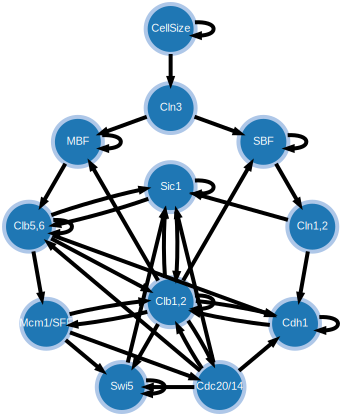

'Yeast-IG.pdf'

In [29]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='6,6', concentrate='false', simplify='false', overlap='scale',splines='false',ratio='auto')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='.7', color='#aec7e8', style='filled', fillcolor='#1f77b4', penwidth='4', fontname='Helvetica', fontcolor='white',fontsize='11')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid,d in SG.nodes(data=True):
    nid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    #fillcolor = 'white'
    pSG.node(nid, label=label, pos=pos)


max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    pSG.edge(uid, vid, weight=weight)
    
display(pSG)
# Export
pSG.render("Yeast-IG", cleanup=True)

## Effective Graph

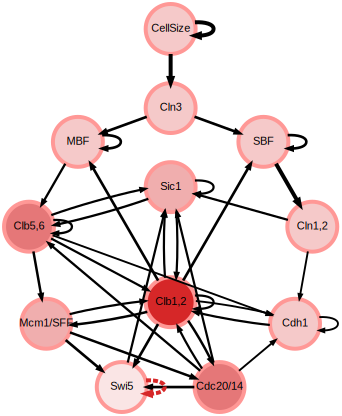

'Yeast-EG.pdf'

In [30]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='6,6', concentrate='false', simplify='false', overlap='scale',splines='false',ratio='auto')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.7', color='#ff9896', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='11')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_outdegree = max([v for n,v in EG0.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG0.nodes(data=True)]

min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
cmap.set_under('#2ca02c')
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=10**-16, vmax=max_outdegree)
# Plot Colorbar
fig = plt.figure(figsize=(.75,1.5))
ax = fig.add_axes([0.1, 0.05, 0.21, 0.9])
ticks = [0,2,4,6,8]
boundaries = np.linspace(-1, max_outdegree,25).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
                               ticks=ticks,spacing='uniform', orientation='vertical',
                               extend='min', format='%.0f')
cb.set_label('Effective out-degree')

#display(fig)
plt.savefig('colorbar.pdf', transparent=True)
plt.close()
#
for nid,d in EG.nodes(data=True):
    dEG0 = EG0.nodes[nid]
    snid = str(nid)
    label = d['label']
    pos = att[d['label']]['pos']
    #width = '{:.2f}'.format(normalize(d['effective_connectivity'], (min_effconn, max_effconn),(0.50,0.80) ) )
    #att[d['label']]['width'] = width
    out_degree = EG0.out_degree(nid, weight='weight')
    if out_degree == 0:
        color = '#98df8a'
        fillcolor = '#2ca02c'
    else:
        rgb = cmap(norm(EG0.out_degree(nid, weight='weigth')))
        hex = mpl.colors.rgb2hex(rgb)
        color = '#ff9896'
        fillcolor = hex
    pEG.node(snid, label=label, pos=pos, color=color, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight'] * max_penwidth )
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid,vid, style='dashed', color='#d62728')
    
# Export
display(pEG)
pEG.render("Yeast-EG", cleanup=True)

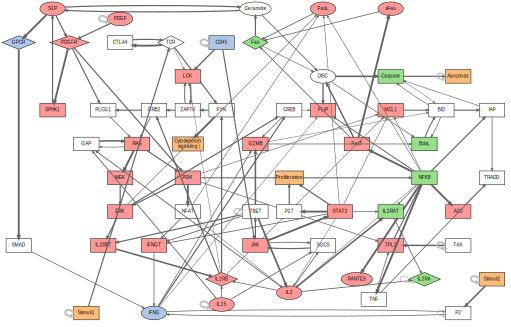

'Leukemia-EGg0p2.pdf'

In [140]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='7,7', concentrate='false', simplify='false', overlap='true',splines='false',ratio='auto', margin='.1')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', style='filled', fillcolor='#515660', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10')
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
colors = ['white','#d62728']
cmap = LinearSegmentedColormap.from_list('custom', colors)
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
#
for nid,d in EG.nodes(data=True):
    label = d['label']
    pos = att[nid].get('pos', '')
    shape = att[nid].get('shape')
    # fillcolor
    #rgb = cmap(norm(EG.out_degree(nid)))
    #fillcolor = mpl.colors.rgb2hex(rgb)
    fillcolor = att[nid].get('fillcolor', '')
    pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] >= 0.2:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    
display(pEG)
# Export
pEG.render("Leukemia-EGt0p2", cleanup=True)